
# Monte Carlo Simulation for Options

Monte Carlo simulation for options pricing works by:

1. Simulating thousands of possible price paths for the underlying asset
2. Calculating the option payoff at expiration for each path
3. Taking the average of these payoffs
4. Discounting this average back to present value

## Types 
1. European Call/Put Option
2. Rainbow Option - Demonstrates pricing of options that depend on multiple underlying assets
3. Path-Dependent Option - Implements pricing for options whose payoff depends on the entire path

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time


def monte_carlo_option_pricing(S, K, r, sigma, T, option_type='call', simulations=100000, timesteps=252, random_seed=42):
    """
    Price options using Monte Carlo simulation.
    
    Parameters:
    -----------
    S : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (in years)
    option_type : str
        'call' or 'put'
    simulations : int
        Number of simulations to run
    timesteps : int
        Number of timesteps in each simulation path
    random_seed : int
        For reproducible results
        
    Returns:
    --------
    dict : A dictionary containing pricing results and simulation details
    """
    
    np.random.seed(random_seed)
    dt = T / timesteps
    
    # Precompute constants
    drift = (r - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)
    
    # Initialize price paths
    prices = np.zeros((simulations, timesteps + 1))
    prices[:, 0] = S
    
    # Simulate price paths
    for t in range(1, timesteps + 1):
        z = np.random.standard_normal(simulations)
        prices[:, t] = prices[:, t-1] * np.exp(drift + vol * z)
    
    # Calculate payoffs at maturity
    if option_type.lower() == 'call':
        payoffs = np.maximum(prices[:, -1] - K, 0)
    elif option_type.lower() == 'put':
        payoffs = np.maximum(K - prices[:, -1], 0)
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    
    # Discount to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    # Calculate confidence interval
    std_error = np.std(payoffs) / np.sqrt(simulations)
    conf_interval = [
        np.exp(-r * T) * (np.mean(payoffs) - 1.96 * std_error),
        np.exp(-r * T) * (np.mean(payoffs) + 1.96 * std_error)
    ]
    
    # Calculate Black-Scholes price for comparison
    bs_price = black_scholes(S, K, r, sigma, T, option_type)
    
    results = {
        'option_price': option_price,
        'confidence_interval': conf_interval,
        'black_scholes_price': bs_price,
        'error_vs_bs': option_price - bs_price,
        'relative_error': (option_price - bs_price) / bs_price if bs_price != 0 else np.nan,
        'simulations': simulations,
        'timesteps': timesteps
    }
    
    return results


def black_scholes(S, K, r, sigma, T, option_type='call'):
    """
    Black-Scholes formula for option pricing (for comparison).
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    
    return price


def visualize_price_paths(S, K, r, sigma, T, num_paths=10, timesteps=252):
    """
    Visualize some sample price paths and option payoff.
    """
    np.random.seed(42)
    dt = T / timesteps
    
    # Precompute constants
    drift = (r - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)
    
    # Initialize price paths
    prices = np.zeros((num_paths, timesteps + 1))
    prices[:, 0] = S
    
    # Simulate price paths
    for t in range(1, timesteps + 1):
        z = np.random.standard_normal(num_paths)
        prices[:, t] = prices[:, t-1] * np.exp(drift + vol * z)
    
    # Time points
    time_points = np.linspace(0, T, timesteps + 1)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    for i in range(num_paths):
        plt.plot(time_points, prices[i, :], alpha=0.5)
    
    plt.axhline(y=K, color='r', linestyle='--', alpha=0.5, label=f'Strike Price (K={K})')
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.title(f'Monte Carlo Simulation: {num_paths} Sample Stock Price Paths')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt


def compare_convergence(S, K, r, sigma, T, option_type='call', max_simulations=100000, step=5000):
    """
    Analyze the convergence of Monte Carlo simulation compared to Black-Scholes.
    """
    start_time = time.time()
    
    simulation_counts = np.arange(step, max_simulations + step, step)
    mc_prices = []
    
    # Calculate Black-Scholes price
    bs_price = black_scholes(S, K, r, sigma, T, option_type)
    
    # Calculate MC prices for different simulation counts
    for n in simulation_counts:
        result = monte_carlo_option_pricing(S, K, r, sigma, T, option_type, simulations=n)
        mc_prices.append(result['option_price'])
    
    # Convert to numpy array
    mc_prices = np.array(mc_prices)
    
    # Calculate error
    errors = np.abs(mc_prices - bs_price)
    relative_errors = errors / bs_price
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(simulation_counts, mc_prices, 'b-', label='Monte Carlo Price')
    plt.axhline(y=bs_price, color='r', linestyle='--', label=f'Black-Scholes Price: {bs_price:.4f}')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.title(f'Convergence of Monte Carlo Pricing: {option_type.capitalize()} Option')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.loglog(simulation_counts, relative_errors, 'g-')
    plt.xlabel('Number of Simulations (log scale)')
    plt.ylabel('Relative Error (log scale)')
    plt.title('Relative Error vs. Number of Simulations')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    results = {
        'time_taken': time_taken,
        'final_error': relative_errors[-1],
        'simulation_counts': simulation_counts,
        'mc_prices': mc_prices
    }
    
    return plt, results


European Call Option:
Monte Carlo Price: $10.4273
95% Confidence Interval: [$10.3365, $10.5181]
Black-Scholes Price: $10.4506
Relative Error: -0.222584%

European Put Option:
Monte Carlo Price: $5.5745
95% Confidence Interval: [$5.5208, $5.6282]
Black-Scholes Price: $5.5735
Relative Error: 0.016919%


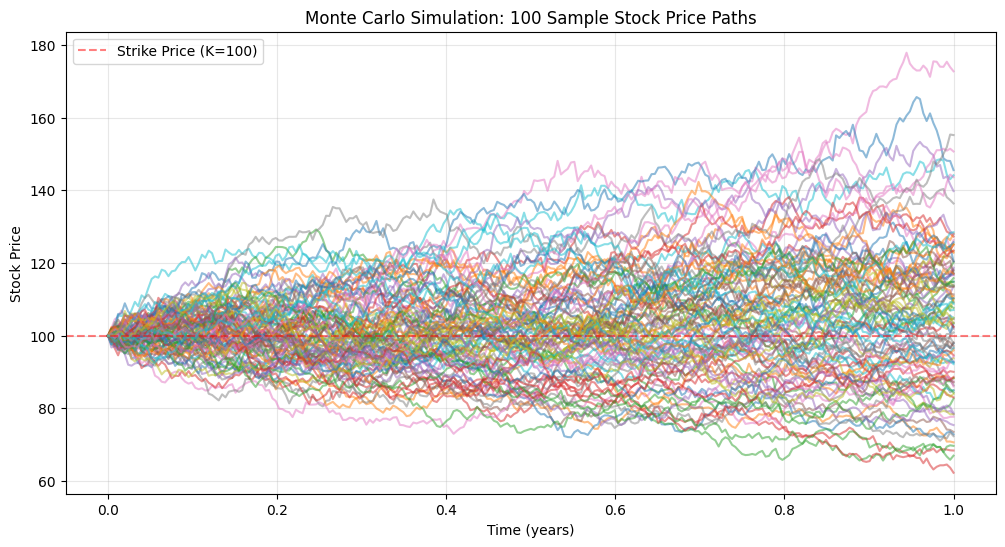

In [10]:
# Option parameters
S = 100      # Current stock price
K = 100      # Strike price
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
T = 1        # Time to maturity (in years)

# Price European call option
result_call = monte_carlo_option_pricing(S, K, r, sigma, T, option_type='call')
print("\nEuropean Call Option:")
print(f"Monte Carlo Price: ${result_call['option_price']:.4f}")
print(f"95% Confidence Interval: [${result_call['confidence_interval'][0]:.4f}, ${result_call['confidence_interval'][1]:.4f}]")
print(f"Black-Scholes Price: ${result_call['black_scholes_price']:.4f}")
print(f"Relative Error: {result_call['relative_error']*100:.6f}%")

# Price European put option
result_put = monte_carlo_option_pricing(S, K, r, sigma, T, option_type='put')
print("\nEuropean Put Option:")
print(f"Monte Carlo Price: ${result_put['option_price']:.4f}")
print(f"95% Confidence Interval: [${result_put['confidence_interval'][0]:.4f}, ${result_put['confidence_interval'][1]:.4f}]")
print(f"Black-Scholes Price: ${result_put['black_scholes_price']:.4f}")
print(f"Relative Error: {result_put['relative_error']*100:.6f}%")

# Visualize some sample price paths
plt = visualize_price_paths(S, K, r, sigma, T, num_paths=100)
plt.show()

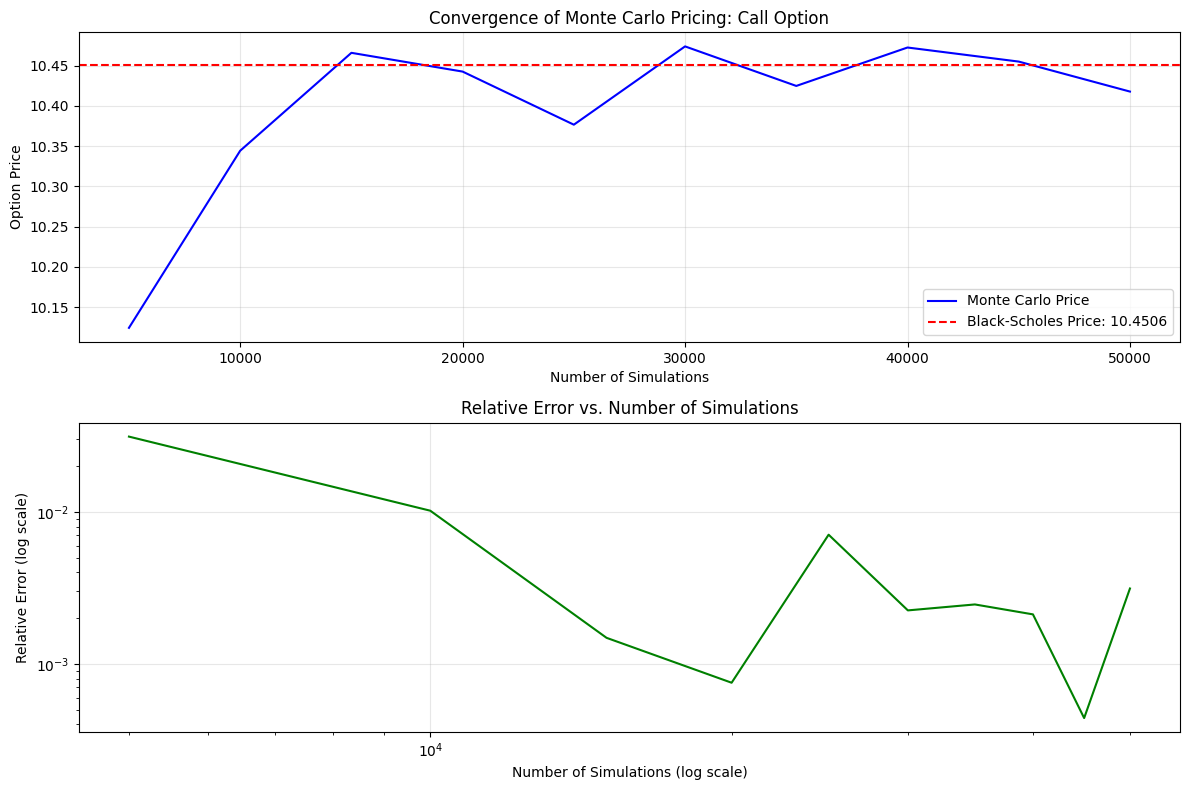


Convergence analysis completed in 1.42 seconds
Final relative error with 50000 simulations: 0.31283507%


In [7]:
# Analyze convergence
plt, conv_results = compare_convergence(S, K, r, sigma, T, option_type='call', max_simulations=50000)
plt.show()

print(f"\nConvergence analysis completed in {conv_results['time_taken']:.2f} seconds")
print(f"Final relative error with {conv_results['simulation_counts'][-1]} simulations: {conv_results['final_error']*100:.8f}%")

## Rainbow Option Example - Demonstrates pricing of options that depend on multiple underlying assets:

- Best-of options (pays the maximum return of all assets)
- Worst-of options (pays the minimum return of all assets)
- Basket options (pays based on the average price of all assets)
- Spread options (pays based on the difference between asset prices)

Simulating asset paths...


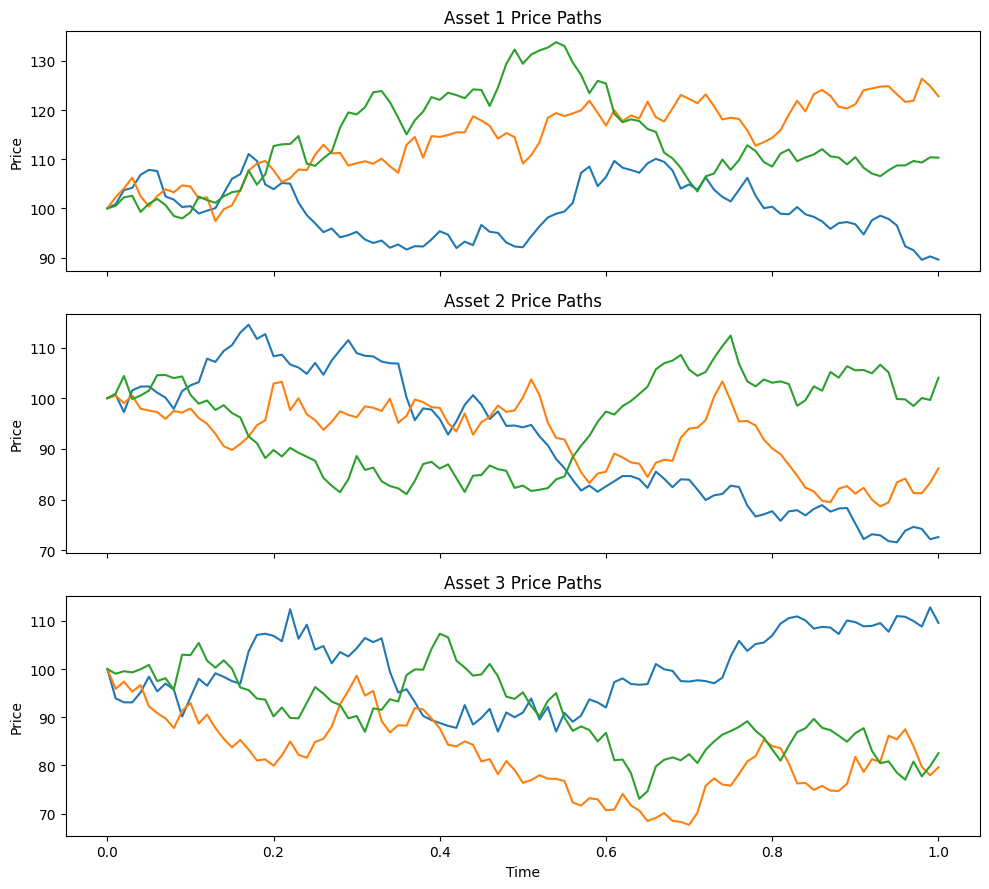


Rainbow Option Price: 0.1704
Standard Error: 0.0008

Rainbow Option Greeks:
  Delta_1: 0.0103
  Delta_2: 0.0218
  Delta_3: 0.0115


In [ ]:
from scipy.linalg import cholesky

def generate_correlated_samples(n, correlation_matrix, num_samples):
    """
    Generate n correlated random samples from a standard normal distribution
    using Cholesky decomposition as described in the writeup.
    
    Parameters:
    - n: Number of variables
    - correlation_matrix: n x n correlation matrix
    - num_samples: Number of samples to generate
    
    Returns:
    - Array of shape (num_samples, n) containing correlated random samples
    """
    # Perform Cholesky decomposition on the correlation matrix
    # Lower triangular matrix L such that L * L.T = correlation_matrix
    L = cholesky(correlation_matrix, lower=True)
    
    # Generate independent random samples from standard normal distribution
    independent_samples = np.random.standard_normal(size=(num_samples, n))
    
    # Apply the Cholesky decomposition to get correlated samples
    correlated_samples = independent_samples @ L.T
    
    return correlated_samples


def simulate_multi_asset_paths(initial_values, growth_rates, volatilities, 
                               correlation_matrix, T, dt, num_paths):
    """
    Simulate paths for multiple correlated assets.
    
    Parameters:
    - initial_values: List of initial values for each asset
    - growth_rates: List of risk-neutral growth rates for each asset
    - volatilities: List of volatilities for each asset
    - correlation_matrix: Correlation matrix between assets
    - T: Time horizon
    - dt: Time step
    - num_paths: Number of paths to simulate
    
    Returns:
    - Array of shape (n_assets, num_paths, num_steps+1) containing simulated paths
    """
    n = len(initial_values)  # Number of assets
    num_steps = int(T / dt)
    
    # Initialize array to store all paths for all assets
    all_paths = np.zeros((n, num_paths, num_steps + 1))
    
    # Set initial values
    for i in range(n):
        all_paths[i, :, 0] = initial_values[i]
    
    # Simulate paths
    for t in range(1, num_steps + 1):
        # Generate correlated random samples for this time step
        correlated_samples = generate_correlated_samples(n, correlation_matrix, num_paths)
        
        for i in range(n):
            # Using the logarithmic version of the formula (Equation 21.7.4)
            # S(t + Δt) = S(t)exp[(μ - σ²/2)Δt + σε√Δt]
            drift = (growth_rates[i] - 0.5 * volatilities[i]**2) * dt
            diffusion = volatilities[i] * correlated_samples[:, i] * np.sqrt(dt)
            all_paths[i, :, t] = all_paths[i, :, t-1] * np.exp(drift + diffusion)
    
    return all_paths

def price_derivative(all_paths, payoff_function, discount_rate=0.05):
    """
    Price a derivative using Monte Carlo simulation.
    
    Parameters:
    - all_paths: Simulated paths for all assets
    - payoff_function: Function that calculates the payoff of the derivative
                      given the final values of the assets
    - discount_rate: Risk-free rate for discounting
    
    Returns:
    - Estimated price of the derivative
    - Standard error of the estimate
    """
    # Extract final values of all assets for each path
    n_assets = all_paths.shape[0]
    num_paths = all_paths.shape[1]
    T = all_paths.shape[2] - 1  # Assuming dt = 1/steps
    
    final_values = np.zeros((num_paths, n_assets))
    for i in range(n_assets):
        final_values[:, i] = all_paths[i, :, -1]
    
    # Calculate payoffs for each path
    payoffs = np.array([payoff_function(path) for path in final_values])
    
    # Discount payoffs
    discount_factor = np.exp(-discount_rate * T)
    discounted_payoffs = payoffs * discount_factor
    
    # Estimate price and standard error
    price_estimate = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(num_paths)
    
    return price_estimate, std_error

def plot_asset_paths(all_paths, asset_names=None, num_paths_to_plot=5, T=1.0):
    """
    Plot simulated paths for each asset.
    
    Parameters:
    - all_paths: Simulated paths for all assets
    - asset_names: List of names for each asset
    - num_paths_to_plot: Number of paths to plot for each asset
    - T: Time horizon
    """
    n_assets = all_paths.shape[0]
    num_steps = all_paths.shape[2] - 1
    
    if asset_names is None:
        asset_names = [f'Asset {i+1}' for i in range(n_assets)]
    
    fig, axes = plt.subplots(n_assets, 1, figsize=(10, 3*n_assets), sharex=True)
    if n_assets == 1:
        axes = [axes]
    
    time_points = np.linspace(0, T, num_steps + 1)
    
    for i in range(n_assets):
        random_paths = np.random.choice(all_paths.shape[1], num_paths_to_plot, replace=False)
        for path_idx in random_paths:
            axes[i].plot(time_points, all_paths[i, path_idx, :])
        
        axes[i].set_title(f'{asset_names[i]} Price Paths')
        axes[i].set_ylabel('Price')
    
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()

def calculate_multi_asset_greeks(initial_values, growth_rates, volatilities, correlation_matrix,
                              T, dt, num_paths, payoff_function, perturb_amount=0.01, discount_rate=0.05):
    """
    Calculate Greek letters (Delta) for multi-asset derivatives using finite difference method.
    
    Parameters:
    - initial_values: List of initial values for each asset
    - growth_rates: List of risk-neutral growth rates for each asset
    - volatilities: List of volatilities for each asset
    - correlation_matrix: Correlation matrix between assets
    - T: Time horizon
    - dt: Time step
    - num_paths: Number of paths to simulate
    - payoff_function: Function that calculates the payoff of the derivative
    - perturb_amount: Amount to perturb the asset price for finite difference
    - discount_rate: Risk-free rate for discounting
    
    Returns:
    - Dictionary of Delta values for each asset
    """
    # Simulate base paths
    all_paths = simulate_multi_asset_paths(
        initial_values, growth_rates, volatilities, 
        correlation_matrix, T, dt, num_paths
    )
    
    # Calculate base price
    base_price, _ = price_derivative(all_paths, payoff_function, discount_rate)
    
    # Calculate Delta for each asset
    deltas = {}
    n_assets = len(initial_values)
    
    for i in range(n_assets):
        # Perturb initial value for asset i
        perturbed_initials = initial_values.copy()
        perturbed_initials[i] *= (1 + perturb_amount)
        
        # Simulate paths with perturbed initial value
        perturbed_paths = simulate_multi_asset_paths(
            perturbed_initials, growth_rates, volatilities, 
            correlation_matrix, T, dt, num_paths
        )
        
        # Calculate price with perturbed values
        perturbed_price, _ = price_derivative(perturbed_paths, payoff_function, discount_rate)
        
        # Calculate Delta using finite difference
        delta = (perturbed_price - base_price) / (perturb_amount * initial_values[i])
        deltas[f'Delta_{i+1}'] = delta
    
    return deltas


# Parameters
n_assets = 3  # Number of assets
initial_values = [100.0, 100.0, 100.0]  # Initial prices
growth_rates = [0.05, 0.06, 0.04]  # Risk-neutral growth rates
volatilities = [0.2, 0.25, 0.3]  # Volatilities

# Correlation matrix
correlation_matrix = np.array([
    [1.0, 0.5, 0.3],
    [0.5, 1.0, 0.4],
    [0.3, 0.4, 1.0]
])

T = 1.0  # Time horizon (1 year)
dt = 0.01  # Time step
num_paths = 50000  # Number of simulation paths

# Risk-free rate for discounting
risk_free_rate = 0.03

# Simulate asset paths
print("Simulating asset paths...")
simulated_paths = simulate_multi_asset_paths(
    initial_values, growth_rates, volatilities, 
    correlation_matrix, T, dt, num_paths
)

# Plot some sample paths
asset_names = ['Asset 1', 'Asset 2', 'Asset 3']
plot_asset_paths(simulated_paths, asset_names, num_paths_to_plot=3)

# Define a rainbow option payoff
def rainbow_option_payoff(final_values, strike=100.0):
    """Payoff for a rainbow option that pays the maximum of all assets minus the strike."""
    max_price = np.max(final_values)
    return max(max_price - strike, 0)

# Price the rainbow option
rainbow_price, rainbow_se = price_derivative(
    simulated_paths, 
    lambda x: rainbow_option_payoff(x)
)

print(f"\nRainbow Option Price: {rainbow_price:.4f}")
print(f"Standard Error: {rainbow_se:.4f}")

# Calculate Greeks for the rainbow option
rainbow_greeks = calculate_multi_asset_greeks(
    initial_values, growth_rates, volatilities, correlation_matrix,
    T, dt, num_paths, lambda x: rainbow_option_payoff(x),
    discount_rate=risk_free_rate
)

print("\nRainbow Option Greeks:")
for key, value in rainbow_greeks.items():
    print(f"  {key}: {value:.4f}")


## Path-Dependent Option Pricing - Implements pricing for options whose payoff depends on the entire path:

- Asian options (depend on average price over time)
- Lookback options (depend on maximum or minimum price over time)
- Barrier options (depend on whether price crosses a barrier)
- Basket Asian options (depend on average price of multiple assets over time)


In [14]:
# def simulate_single_asset_path(S0, mu, sigma, T, dt, num_paths):
#     """
#     Simulate paths for a single asset using geometric Brownian motion.
    
#     Parameters:
#     - S0: Initial asset price
#     - mu: Risk-neutral drift rate
#     - sigma: Volatility
#     - T: Time horizon
#     - dt: Time step
#     - num_paths: Number of paths to simulate
    
#     Returns:
#     - Array of simulated paths
#     """
#     num_steps = int(T / dt)
    
#     # Initialize array to store all paths
#     paths = np.zeros((num_paths, num_steps + 1))
#     paths[:, 0] = S0
    
#     # Generate random samples for each time step
#     Z = np.random.standard_normal(size=(num_paths, num_steps))
    
#     # Simulate paths using the logarithmic version (equation 21.7.4)
#     for t in range(1, num_steps + 1):
#         drift = (mu - 0.5 * sigma**2) * dt
#         diffusion = sigma * Z[:, t-1] * np.sqrt(dt)
#         paths[:, t] = paths[:, t-1] * np.exp(drift + diffusion)
    
#     return paths


def simulate_single_asset_direct(S0, mu, sigma, T, num_paths):
    """
    Directly simulate the final value of a single asset using equation 21.7.5.
    
    Parameters:
    - S0: Initial asset price
    - mu: Risk-neutral drift rate
    - sigma: Volatility
    - T: Time horizon
    - num_paths: Number of simulations
    
    Returns:
    - Array of final asset values
    """
    Z = np.random.standard_normal(num_paths)
    drift = (mu - 0.5 * sigma**2) * T
    diffusion = sigma * Z * np.sqrt(T)
    final_values = S0 * np.exp(drift + diffusion)
    
    return final_values

def price_european_option(S0, K, r, sigma, T, option_type='call', method='analytical', num_paths=10000):
    """
    Price a European option using either the Black-Scholes formula or Monte Carlo simulation.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free rate
    - sigma: Volatility
    - T: Time to expiration
    - option_type: 'call' or 'put'
    - method: 'analytical' (Black-Scholes) or 'monte_carlo'
    - num_paths: Number of paths for Monte Carlo simulation
    
    Returns:
    - Option price
    - Standard error (for Monte Carlo only)
    """
    if method == 'analytical':
        # Black-Scholes formula
        d1 = (np.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if option_type == 'call':
            price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            return price, 0
        else:  # put
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
            return price, 0
    
    elif method == 'monte_carlo':
        # Monte Carlo simulation
        final_values = simulate_single_asset_direct(S0, r, sigma, T, num_paths)
        
        if option_type == 'call':
            payoffs = np.maximum(final_values - K, 0)
        else:  # put
            payoffs = np.maximum(K - final_values, 0)
        
        # Discount payoffs
        discount_factor = np.exp(-r * T)
        discounted_payoffs = payoffs * discount_factor
        
        # Calculate price and standard error
        price = np.mean(discounted_payoffs)
        std_error = np.std(discounted_payoffs) / np.sqrt(num_paths)
        
        return price, std_error




def price_path_dependent_option(all_paths, payoff_function, discount_rate=0.05):
    """
    Price a path-dependent option using Monte Carlo simulation.
    
    Parameters:
    - all_paths: Simulated paths for all assets
    - payoff_function: Function that calculates the payoff of the derivative
                       given the entire path of the assets
    - discount_rate: Risk-free rate for discounting
    
    Returns:
    - Estimated price of the derivative
    - Standard error of the estimate
    """
    n_assets = all_paths.shape[0]
    num_paths = all_paths.shape[1]
    num_steps = all_paths.shape[2] - 1
    T = num_steps  # Assuming dt = 1/steps
    
    # Calculate payoffs for each path
    payoffs = np.zeros(num_paths)
    for i in range(num_paths):
        # Extract path for all assets
        path = np.array([all_paths[asset_idx, i, :] for asset_idx in range(n_assets)])
        payoffs[i] = payoff_function(path)
    
    # Discount payoffs
    discount_factor = np.exp(-discount_rate * T)
    discounted_payoffs = payoffs * discount_factor
    
    # Estimate price and standard error
    price_estimate = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(num_paths)
    
    return price_estimate, std_error


def calculate_greeks(S0, K, r, sigma, T, option_type='call', delta_S=0.01):
    """
    Calculate option Greeks using finite difference methods.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - r: Risk-free rate
    - sigma: Volatility
    - T: Time to expiration
    - option_type: 'call' or 'put'
    - delta_S: Change in stock price for finite difference
    
    Returns:
    - Dictionary of Greeks (Delta, Gamma, Theta, Vega, Rho)
    """
    # Base price
    base_price, _ = price_european_option(S0, K, r, sigma, T, option_type, 'analytical')
    
    # Delta: dV/dS
    up_price, _ = price_european_option(S0 + delta_S, K, r, sigma, T, option_type, 'analytical')
    delta = (up_price - base_price) / delta_S
    
    # Gamma: d²V/dS²
    down_price, _ = price_european_option(S0 - delta_S, K, r, sigma, T, option_type, 'analytical')
    gamma = (up_price - 2*base_price + down_price) / (delta_S**2)
    
    # Theta: -dV/dt
    delta_t = 0.01
    future_price, _ = price_european_option(S0, K, r, sigma, T - delta_t, option_type, 'analytical')
    theta = -(future_price - base_price) / delta_t
    
    # Vega: dV/dσ
    delta_sigma = 0.005
    vol_up_price, _ = price_european_option(S0, K, r, sigma + delta_sigma, T, option_type, 'analytical')
    vega = (vol_up_price - base_price) / delta_sigma
    
    # Rho: dV/dr
    delta_r = 0.001
    rate_up_price, _ = price_european_option(S0, K, r + delta_r, sigma, T, option_type, 'analytical')
    rho = (rate_up_price - base_price) / delta_r
    
    return {
        'Delta': delta,
        'Gamma': gamma,
        'Theta': theta,
        'Vega': vega,
        'Rho': rho
    }

def plot_convergence(func, true_value, max_trials=100000, points=20, title="Monte Carlo Convergence"):
    """
    Plot the convergence of a Monte Carlo simulation.
    
    Parameters:
    - func: Function that takes num_paths parameter and returns an estimate and standard error
    - true_value: True value of the quantity being estimated
    - max_trials: Maximum number of trials to run
    - points: Number of points to plot
    - title: Title of the plot
    """
    trial_counts = np.logspace(2, np.log10(max_trials), points).astype(int)
    estimates = []
    errors = []
    times = []
    
    for trials in trial_counts:
        start_time = time.time()
        estimate, error = func(num_paths=trials)
        end_time = time.time()
        
        estimates.append(estimate)
        errors.append(error)
        times.append(end_time - start_time)
    
    # Absolute error
    abs_errors = np.abs(np.array(estimates) - true_value)
    
    # Plot convergence of estimate
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.loglog(trial_counts, abs_errors, 'bo-')
    plt.loglog(trial_counts, 1 / np.sqrt(trial_counts), 'r--', label='1/√M')
    plt.xlabel('Number of Trials (M)')
    plt.ylabel('Absolute Error')
    plt.title(f'{title} - Error vs. Trials')
    plt.grid(True)
    plt.legend()
    
    # Plot time vs. trials
    plt.subplot(1, 2, 2)
    plt.loglog(trial_counts, times, 'go-')
    plt.xlabel('Number of Trials (M)')
    plt.ylabel('Computation Time (s)')
    plt.title('Computation Time vs. Trials')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Asian Option Price: 0.3026
Standard Error: 0.0019

European Call Option Pricing Comparison:
  Black-Scholes Price: 10.4506
  Monte Carlo Price: 10.4247 (SE: 0.0466)

European Call Option Greeks:
  Delta: 0.6369
  Gamma: 0.0188
  Theta: 6.4246
  Vega: 37.5479
  Rho: 53.2996

Analyzing Monte Carlo convergence...


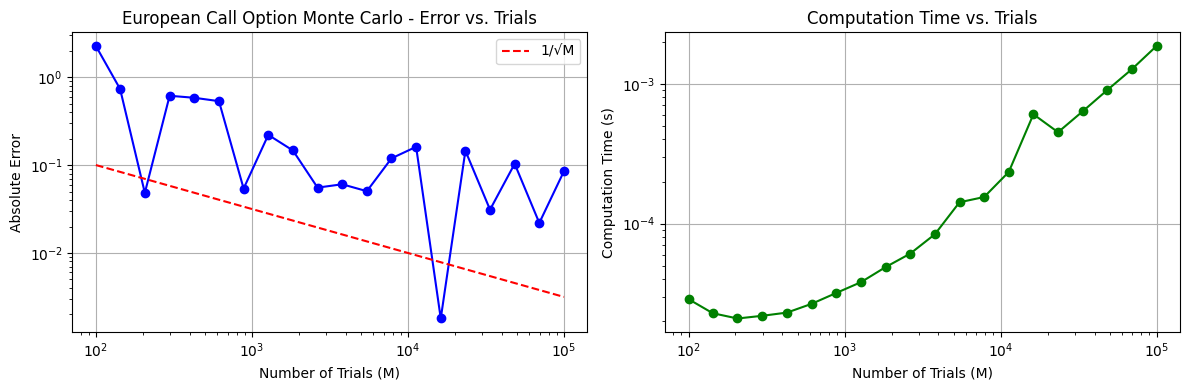

In [15]:
# Example for a path-dependent option (Asian option)
def asian_option_payoff(path):
    """Payoff for an Asian option based on the average price of the first asset."""
    asset_path = path[0, :]  # First asset
    avg_price = np.mean(asset_path)
    strike = 100.0
    return max(avg_price - strike, 0)

# Price the Asian option
asian_price, asian_se = price_path_dependent_option(
    simulated_paths, 
    asian_option_payoff,
    discount_rate=risk_free_rate
)

print(f"\nAsian Option Price: {asian_price:.4f}")
print(f"Standard Error: {asian_se:.4f}")

# Compare Monte Carlo with Black-Scholes for a simple European option
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.2
T = 1.0

bs_price, _ = price_european_option(S0, K, r, sigma, T, 'call', 'analytical')
mc_price, mc_se = price_european_option(S0, K, r, sigma, T, 'call', 'monte_carlo', 100000)

print("\nEuropean Call Option Pricing Comparison:")
print(f"  Black-Scholes Price: {bs_price:.4f}")
print(f"  Monte Carlo Price: {mc_price:.4f} (SE: {mc_se:.4f})")

# Calculate and print Greeks
greeks = calculate_greeks(S0, K, r, sigma, T, 'call')
print("\nEuropean Call Option Greeks:")
for greek, value in greeks.items():
    print(f"  {greek}: {value:.4f}")

# Demonstrate convergence
def european_call_mc(num_paths):
    return price_european_option(S0, K, r, sigma, T, 'call', 'monte_carlo', num_paths)

print("\nAnalyzing Monte Carlo convergence...")
plot_convergence(european_call_mc, bs_price, max_trials=100000, 
                    title="European Call Option Monte Carlo")